# Clustering Example

In this example we cluster a short trajectory (1000 frames) of the disordered peptide [hiAPP](https://www.ncbi.nlm.nih.gov/pubmed/24021023)

<a id='Table of Contents'></a><h3>Table of Contents</h3>
<a href='#load_env'>Load Environment</a>  
<a href='#download_data'>Donwload Data</a>  
<a href='#load_traj'>Loading the Trajectory</a>  
<a href='#vis_traj'>Quick Trajectory Visualization</a>  
<a href='#clustering'>Clustering</a>  
<a href='#vis_cluster_tree'>Quick View of the Clustering Tree</a>  
<a href='#pdb_repr'>Extract PDB Files for Representative Structures</a>  
<a href='#bench_xray'>"Experimental" X-Ray profile</a>  
<a href='#fit_tree'>Fit the Tree Against the Experimental Profile</a>  
<a href='#xray_crysol'>Calculation of X-Ray Profiles with CRYSOL</a>  
<a href='#calc_rg'>Calculate Radius of Gyration</a>  
<a href='#best_fit'>Analysis of the Tree Level with Best Fit to Experimental Profile</a>  
<a href='#weight_cluster'>Weight of Each Cluster</a>  
<a href='#node_repr'>Representative Structures of the Nodes</a>  
<a href='#pdb_by_cluster'>List of PDB Structures for each Cluster</a>  

<a id='Secondary Structure'></a><b>Secondary Structure Analysis</b>  
<a href='#ss_nodes'>Calculate Secondary Structure for Nodes of the Tree</a>  
<a href='#ss_content_nodes'>Secondary Structure Content for Matching Nodes</a>  
<a href='#ss_prob_nodes'>Secondary Structure Probabilities of Matching Nodes</a>  
<a href='#ss_ensemble_nodes'>Ensemble Secondary Structure of Matching Nodes</a>  

<a href='#rg_content'>Rg Content for Matching Nodes</a>  
<a href='#res_map'>Residue Contact Map</a>  
<a href='#save'>Save the State of the Tree</a>  


(<a href='#Table of Contents'>Top</a>)<a id='load_env'></a><h3>Load Environment</h3>

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

import os
import sys
import subprocess
import numpy as np
import MDAnalysis as mda
import nglview
from tqdm import tqdm
import pathos
import multiprocessing
from scipy.cluster.hierarchy import dendrogram

from idpflex.cnextend import load_tree
from idpflex.cluster import cluster_trajectory
from idpflex.properties import (SaxsProperty, SecondaryStructureProperty, ResidueContactMap,
                                RadiusOfGyration, propagator_size_weighted_sum)
from idpflex.utils import write_frame
from idpflex.bayes import fit_to_depth

(<a href='#Table of Contents'>Top</a>)<a id='download_data'></a><h3>Donwload Data</h3>

It's assumed <code>git</code> is installed in your system. Otherwise,
[follow instructions](http://idpflex.readthedocs.io/en/latest/installation.html#testing-tutorials-data)
to download and unpack your data to <code>/tmp/idpflex_data</code>.

In [2]:
%%bash
idpflex_data_dir="/tmp/idpflex_data"
if [ -d "${idpflex_data_dir}" ]; then
    cd ${idpflex_data_dir}
    git pull --rebase
else
    git clone https://github.com/jmborr/idpflex_data ${idpflex_data_dir}
fi


error: Cannot pull with rebase: You have unstaged changes.


In [3]:
idpflex_data_dir = '/tmp/idpflex_data'
data_dir = os.path.join(idpflex_data_dir, 'data', 'simulation')
print(data_dir)

/tmp/idpflex_data/data/simulation


(<a href='#Table of Contents'>Top</a>)<a id='load_traj'></a><h3>Loading the Trajectory</h3>

In [4]:
simulation = mda.Universe(os.path.join(data_dir, 'hiAPP.pdb'),
                          os.path.join(data_dir, 'hiAPP.xtc'))
print('Number of frames in trajectory is ', simulation.trajectory.n_frames)

('Number of frames in trajectory is ', 1000)


(<a href='#Table of Contents'>Top</a>)<a id='vis_traj'></a><h3>Quick Trajectory Visualization</h3>

In [5]:
w_show = nglview.show_mdanalysis(simulation)
w_show

A Jupyter Widget

(<a href='#Table of Contents'>Top</a>)<a id='clustering'></a><h3>Clustering</h3>

We cluster the trajectory in two steps:
1. cluster the 1000 frames into 100 small clusters, producing 100 representative structures
2. cluster all 100 representative structures in a hierarchichal tree.

The first step will be obtained by splicing the trajectory into segments of 100 frames, and obtaining 10 representatives for each segment. Thus, we obtain a total of 100 representatives. See [clustering](http://idpflex.readthedocs.io/en/latest/idpflex/cluster.html) for more info.

The two steps process makes more sense with large trajectories, for instance, a trajectory of $10^5$ frames that we cluster into 1000 representatives.

In [6]:
cl = cluster_trajectory(simulation, segment_length=100, n_representatives=100)

Clustering the trajectory:
Creating 100 representatives by partitioning 1000 frames into 10 segments
and retrieving 10 representatives from each segment.
    

100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


(<a href='#Table of Contents'>Top</a>)<a id='vis_cluster_tree'></a><h3>Quick View of the Clustering Tree</h3>

In [ ]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('RMSD (Angstroms)')
dendrogram(cl.tree.z,
           #truncate_mode='lastp',  # show only the last p merged clusters
           #p=20,  # show this many cluster at the bottom of the tree
           show_leaf_counts=False,  # otherwise numbers in brackets are counts
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True,  # to get a distribution impression in truncated branches
          )

(<a href='#Table of Contents'>Top</a>)<a id='pdb_repr'></a><h3>Extract PDB Files for Representative Structures</h3>

We extract PDB files for each of the 100 representatives and store under directory `/tmp/PDB`

In [7]:
pdb_names = ['/tmp/PDB/conf_{}.pdb'.format(idx) for idx in cl.idx]

In [8]:
subprocess.call(['mkdir', '-p', '/tmp/PDB'])  # directory to store the PDB files
for idx, name in tqdm(list(zip(cl.idx, pdb_names))):
    write_frame(simulation, idx, name)

100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


(<a href='#Table of Contents'>Top</a>)<a id='xray_crysol'></a><h3>Calculation of X-Ray Profiles with CRYSOL</h3>

It is assumed that `crysol` is installed in your computer. We store a profile for each representative in directory `/tmp/CRYSOL`.

In [9]:
pool = pathos.pools.ProcessPool(processes=multiprocessing.cpu_count())
profiles = list(tqdm(pool.map(SaxsProperty().from_crysol_pdb, pdb_names), total=len(pdb_names)))

100%|██████████| 100/100 [00:00<00:00, 332090.58it/s]


Once we have the profiles for the 100 representatives, we can calculate the X-ray profiles for any node of the hierarchical tree

In [10]:
crysol_names = ['/tmp/CRYSOL/conf_{}.int'.format(idx) for idx in cl.idx]

In [11]:
[profile.to_ascii(name) for profile, name in zip(profiles, crysol_names)]
propagator_size_weighted_sum(profiles, cl.tree)

(<a href='#Table of Contents'>Top</a>)<a id='calc_rg'></a><h3>Calculate Radius of Gyration</h3>

We calculate $Rg$ for each representative and propagate up the cluster tree. Property name is `'rg'`. This radius of gyration does not take into account the hydration layer.  
We plot a histogram of Rg for the 100 representatives.

<IPython.core.display.Javascript object>


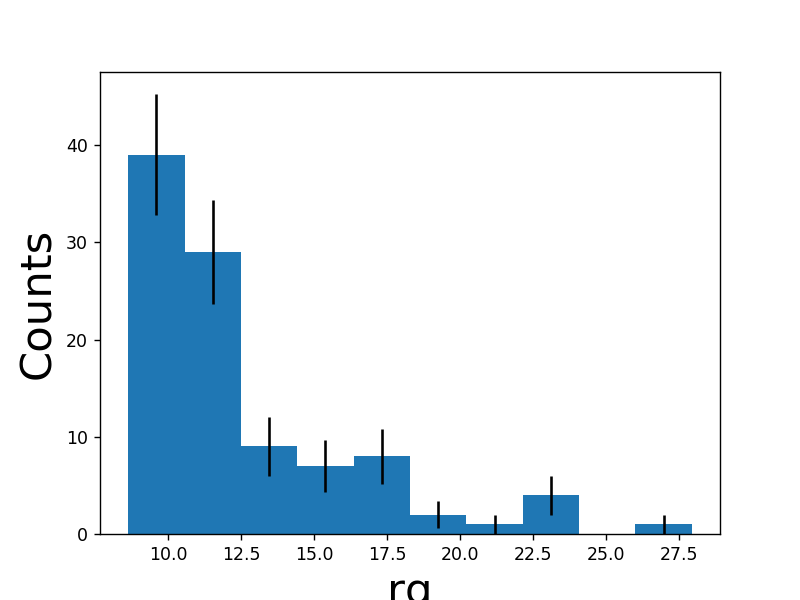

In [12]:
rg_properties = [RadiusOfGyration().from_pdb(name) for name in pdb_names]  # Rg for each representative
propagator_size_weighted_sum(rg_properties, cl.tree)
cl.tree.root['rg'].plot(kind='histogram', errors=True)

(<a href='#Table of Contents'>Top</a>)<a id='bench_xray'></a><h3>"Experimental" X-Ray profile</h3>

We do not have an experimental profile], so we are going to create a fake experimental profile using the profiles from some of the nodes. The task for the fit engine will be to identify which nodes did we use.

Starting from the top of the tree (the root node), we will descend to `level=6`, which contains 7 nodes (the first level is the root node corresponding to `level=0`) We will assign different weights to each of the seven profiles and construct our profile with these weigths.

The profile will be stored as a [SAXS property](http://idpflex.readthedocs.io/en/latest/idpflex/properties.html#idpflex.properties.SaxsProperty)

In [13]:
nodes = cl.tree.nodes_at_depth(6)
weights = [0.00, 0.13, 0.0, 0.55, 0.0, 0.32, 0.00]  # the weights add up to one
# x are the Q-values
x = nodes[0]['saxs'].x
# y are the intensities
y = weights[0] * nodes[0]['saxs'].y
for i, node in enumerate(nodes[1:]):
    y += weights[i] * node['saxs'].y
# Errors simple taken as 10% of the intensities
e = y * 0.1
# Now we create our X-Ray property
exp_saxs = SaxsProperty(qvalues=x, profile=y, errors=e)

we can plot the property

<IPython.core.display.Javascript object>


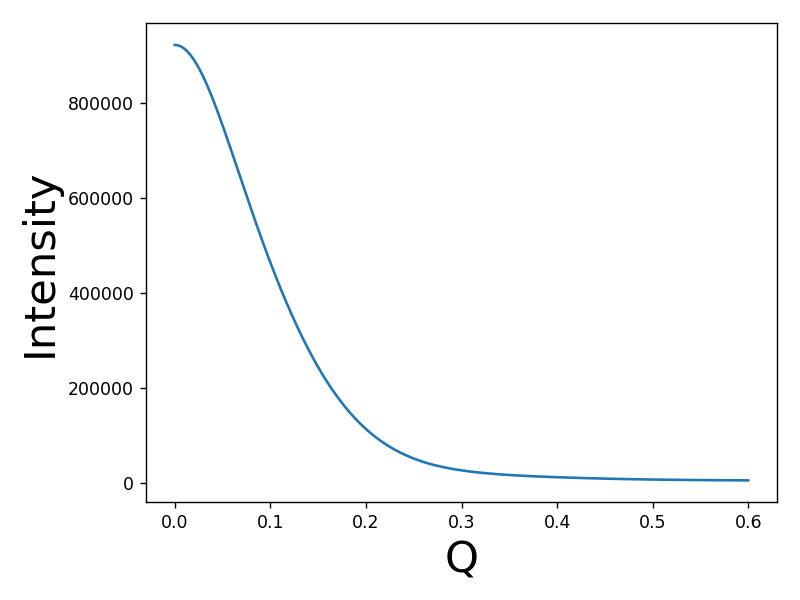

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(exp_saxs.x, exp_saxs.y)
ax.set_xlabel('Q', size=25)
ax.set_ylabel('Intensity', size=25)
plt.tight_layout()

(<a href='#Table of Contents'>Top</a>)<a id='fit_tree'></a><h3>Fit the Tree Against the Experimental Profile</h3>

Starting from the root node, we fit each tree level against the experimental profile, up to a maximum depth (in this case, `level=12`. Then we will inquire the goodnes of fit for each level

In [15]:
fits = fit_to_depth(cl.tree, exp_saxs, exp_saxs.name, max_depth=9)

Fitting at depth = 0
Fitting at depth = 1
Fitting at depth = 2
Fitting at depth = 3
Fitting at depth = 4
Fitting at depth = 5
Fitting at depth = 6
Fitting at depth = 7
Fitting at depth = 8
Fitting at depth = 9


`fits` is a list of [ModelResult](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult) instances, one result for every level. We extract the goodness of fit `\chi^2` and plot versus level

<IPython.core.display.Javascript object>


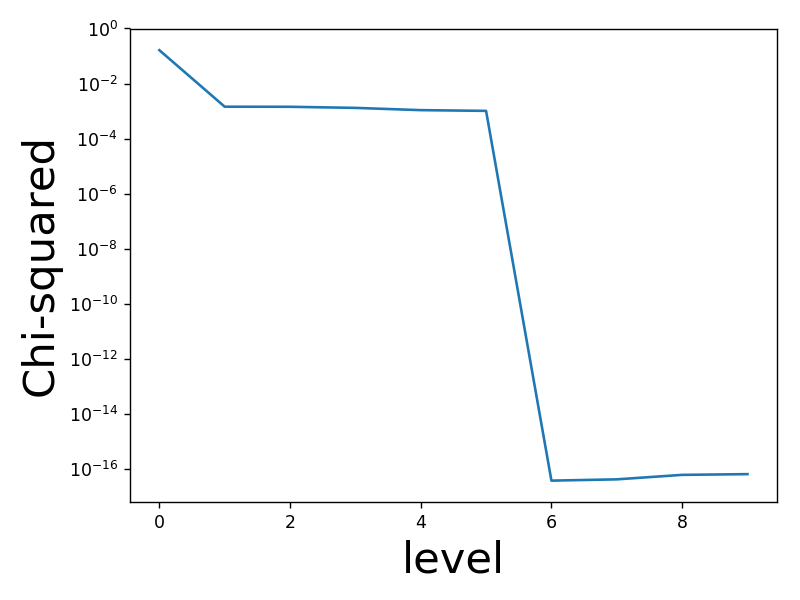

In [16]:
chi2 = [fit.redchi for fit in fits]
fig, ax = plt.subplots(1,1)
ax.set_xlabel('level', size=25)
ax.set_ylabel('Chi-squared', size=25)
ax.set_yscale('log')
ax.plot(chi2)
plt.tight_layout()

the steep drop in orders of magnitude for $\chi^2$ at `level=6` indicates the fit engine successfully fitted the experimental profile.

(<a href='#Table of Contents'>Top</a>)<a id='best_fit'></a><h3>Analysis of the Tree Level with Best Fit to Experimental Profile</h3>

In [17]:
best_fit = fits[6]

(<a href='#Table of Contents'>Top</a>)<a id='weight_cluster'></a><h3>Weight of Each Cluster</h3>

We inquire the weight that the fit engine assigned to each of the seven clusters of `level=6`

In [18]:
for key in best_fit.best_values:
    if 'amplitude' in key:
        print(key, '{:4.2f}'.format(best_fit.best_values[key]))
print(['{:4.2f}'.format(x) for x in weights])  # weights used to construct the experimental profile

('n192_amplitude', '0.32')
('n189_amplitude', '0.00')
('n187_amplitude', '0.00')
('n181_amplitude', '0.00')
('n191_amplitude', '0.00')
('n188_amplitude', '0.13')
('n190_amplitude', '0.55')
['0.00', '0.13', '0.00', '0.55', '0.00', '0.32', '0.00']


The order in which the fitted weights are printed is different that the order of the experimental weight. Object `best_fit.best_values` is a python dictionary and order is not guaranteed for this type of object. However, we can use the node id in the amplitude name to sort the fitted weights from smaller to higher node id.

The fit procedure correctly identified that only three out of the seven nodes are contributing to the experimental profile.

(<a href='#Table of Contents'>Top</a>)<a id='node_repr'></a><h3>Representative Structures of the Nodes</h3>

Find a representative structure for each of the three nodes contributing to the match of the experimental profile

In [19]:
node_ids = [188, 190, 192]  # ID's for the clusters matching the experimental profile 
leafs = [cl.tree[id].representative(cl.rmsd) for id in node_ids]
repr_names = [pdb_names[l.id] for l in leafs]  # representative structures for each node
print(repr_names)

['/tmp/PDB/conf_722.pdb', '/tmp/PDB/conf_343.pdb', '/tmp/PDB/conf_555.pdb']


In [20]:
view = nglview.show_file(repr_names[0])
view

A Jupyter Widget

In [23]:
view = nglview.show_file(repr_names[1])
view

A Jupyter Widget

In [24]:
view = nglview.show_file(repr_names[2])
view

A Jupyter Widget

(<a href='#Table of Contents'>Top</a>)<a id='pdb_by_cluster'></a><h3>List of PDB Structures for each Cluster</h3>

We are interested to know which PDB structures comprise each of the three clusters contributing to the fit. Each cluster is made up of a number of mini-centroids, and each mini-centroid has associated a PDB file stored in list `pdb_names`.

We create a file for each of our three clusters, with path `/tmp/node{X}_pdblist.txt` where `{X}` stands up for cluster ID.

In [ ]:
node_ids = [188, 190, 192]  # ID's for the clusters matching the experimental profile 
for id in node_ids:
    pdb_list = [pdb_names[leaf_id] for leaf_id in cl.tree[id].leaf_ids]
    open('/tmp/node{}_pdblist.txt'.format(id), 'w').write('\n'.join(pdb_list))

## Secondary Structure Analysis

(<a href='#Secondary Structure'>Top</a>)<a id='ss_nodes'></a><h3>Calculate Secondary Structure for Nodes of the Tree</h3>

It is neccessary to have DSSP executable in your machine. The default name for the executable is `mkdssp`.

We start by calculating the DSSP profile for each of the 100 representatives using their PDB files. After that we calculate the DSSP profile for the rest of nodes in the tree using the
[propagator](http://idpflex.readthedocs.io/en/latest/idpflex/properties.html#idpflex.properties.propagator_size_weighted_sum).

In [ ]:
ss_profiles = [SecondaryStructureProperty().from_dssp_pdb(name, command='mkdssp') for name in pdb_names]
propagator_size_weighted_sum(ss_profiles, cl.tree)

(<a href='#Secondary Structure'>Top</a>)<a id='ss_content_nodes'></a><h3>Secondary Structure Content for Matching Nodes</h3>

We are interested in the three nodes contributing to the fit of the experimental profile. We plot how much secondary structure each node contains

| Index | DSSP | Color |        Structure             |
|-------|------|-------|------------------------------|
|   0   |  H   |yellow | Alpha helix (4-12)           |
|   1   |  B   | pink  | Isolated beta-bridge residue |
|   2   |  E   | red   | Strand                       |
|   3   |  G   |orange | 3-10 helix                   | 
|   4   |  I   | green | Pi helix                     |
|   5   |  T   |magenta| Turn                         |
|   6   |  S   | cyan  | Bend                         |
|   7   |      | white |Unstructured (coil)           |


In [ ]:
node_ids = [188, 190, 192]  # ID's for the clusters matching the experimental profile 

In [ ]:
[cl.tree[id]['ss'].plot(kind='percents') for id in node_ids]

(<a href='#Secondary Structure'>Top</a>)<a id='ss_prob_nodes'></a><h3>Secondary Structure Probabilities of Matching Nodes</h3>


Each node is actually a cluster or ensemble of structures, out of the 100 representative structures. Thus for a given node, each residue has a certain probability to be in one of the different DSSP states.

| Index | DSSP | Color |        Structure             |
|-------|------|-------|------------------------------|
|   0   |  H   |yellow | Alpha helix (4-12)           |
|   1   |  B   | pink  | Isolated beta-bridge residue |
|   2   |  E   | red   | Strand                       |
|   3   |  G   |orange | 3-10 helix                   | 
|   4   |  I   | green | Pi helix                     |
|   5   |  T   |magenta| Turn                         |
|   6   |  S   | cyan  | Bend                         |
|   7   |      | white |Unstructured (coil)           |


In [ ]:
[cl.tree[id]['ss'].plot(kind='node') for id in node_ids]

(<a href='#Secondary Structure'>Top</a>)<a id='ss_ensemble_nodes'></a><h3>Ensemble Secondary Structure of Matching Nodes</h3>

Each node is actually a cluster or ensemble of structures, out of the 100 representative structures. Thus for a given node we can plot the secondary structure of each structure belonging to the node

| Index | DSSP | Color |        Structure             |
|-------|------|-------|------------------------------|
|   0   |  H   |yellow | Alpha helix (4-12)           |
|   1   |  B   | pink  | Isolated beta-bridge residue |
|   2   |  E   | red   | Strand                       |
|   3   |  G   |orange | 3-10 helix                   | 
|   4   |  I   | green | Pi helix                     |
|   5   |  T   |magenta| Turn                         |
|   6   |  S   | cyan  | Bend                         |
|   7   |      | white |Unstructured (coil)           |


In [ ]:
[cl.tree[id]['ss'].plot(kind='leafs') for id in node_ids]

(<a href='#Table of Contents'>Top</a>)<a id='rg_content'></a><h3>Rg Content for Matching Nodes</h3>
- $\langle Rg\rangle$ for the three matching nodes
- Histogram of Rg values from the representative structures contained in each of the three matching nodes. 

In [ ]:
print([cl.tree[id]['rg'].y for id in node_ids])  # average Rg for each matching node
[cl.tree[id]['rg'].plot(kind='histogram', errors=True) for id in node_ids]  # Rg histogram for each matching node

(<a href='#Table of Contents'>Top</a>)<a id='res_map'></a><h3>Residue Contact Map</h3>

We start by calculating the residue contact map property for each of the 100 representatives, and then propagate the maps up the tree, as usual. Here we deem two residues in contact if any of its two atoms are less than 4.0 Angstroms apart.

In [ ]:
maps = [ResidueContactMap().from_pdb(name, 4.0) for name in tqdm(pdb_names)]
propagator_size_weighted_sum(maps, cl.tree)

If we want to calculate the residue contact maps using only the CA atoms with a 6 Angstroms cut off, the we would write:
```
maps = [ResidueContactMap().from_PDB(name, 6.0, selection='name CA') for name in pdb_names]
```

After calculation of the maps and propagation up the tree, we proceed to plot the map for the three nodes identified during the fittin procedure agains our "experimental" profile.

In [ ]:
[cl.tree[id]['cm'].plot() for id in node_ids]  # The name of the residue contact map property is 'cm'

(<a href='#Table of Contents'>Top</a>)<a id='save'></a><h3>Save the State of the Tree</h3>

We've done a few things! We can save the hiearchical tree along with the calculated properties so that later we can continue our work withougt having to redo the clustering or recalculate the properties.

In [ ]:
sys.setrecursionlimit(10000)
cl.save('/tmp/hiAPP.pck')  # save the tree and properties to a file

Next time we don't need to recalculate the properties. We can load the saved tree:

In [ ]:
copy_of_tree = load_tree('/tmp/hiAPP.pck')

now we can use this tree, for instance, to plot the secondary structure of the third cluster

In [ ]:
id = node_ids[2]  # id of the third cluster
copy_of_tree.tree[id]['ss'].plot(kind='node')